In [1]:
import pandas as pd

## Data preparation

In [2]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('data_with_ports.csv.gz', sep='|', compression='gzip')

C:\Users\Hsin\.conda\envs\venvCyber\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,17,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [4]:
# remove reserved ips
reserved_ips = [
    "0.",       # software
    "10.",      # private network
    "100.",     # private network
    "169.254.", # subnet
    "172.",     # private network
    "192."      # private network
]

df = df[~(df.org.isna() & df.target_ip.str.startswith(tuple(reserved_ips)))]

In [5]:
# fix NaNs in `regions` data for victims that reside in United States and Canada
df.loc[df.raw_country.str.contains("united states|canada", case=False), "region"] = "NA" # NA = North America

# fix comma in string
df.raw_country = df.raw_country.str.replace("<comma>", ",")

# fix `cc` and `region` missing values
df.loc[df.raw_country == "Tonga", "cc"] = "TO"; df.loc[df.raw_country == "Tonga", "region"] = "AP"
df.loc[df.raw_country == "Namibia", "cc"] = "NA"; df.loc[df.raw_country == "Namibia", "region"] = "AF"
df.loc[df.raw_country == "San Marino", "cc"] = "SM"; df.loc[df.raw_country == "San Marino", "region"] = "EU"
df.loc[df.raw_country == "Europe", "region"] = "EU"
df.loc[df.raw_country == "Asia/Pacific Region", "region"] = "AP"

# fix for "France, Metropolitan"
df.loc[df.raw_country.str.contains("france", case=False), "raw_country"] = "France"
df.loc[df.raw_country == "France", "cc"] = "FR"; df.loc[df.raw_country == "France", "region"] = "EU"

In [6]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5719250 entries, 0 to 5721431
Data columns (total 35 columns):
target_ip                 5719250 non-null object
date                      5719250 non-null datetime64[ns]
sensor_id                 5719250 non-null object
service                   5719250 non-null object
start_time                5719250 non-null datetime64[ns]
stop_time                 5719250 non-null datetime64[ns]
duration                  5719250 non-null float64
packets                   5719250 non-null int64
raw_country               5719250 non-null object
raw_as                    5719250 non-null object
raw_hostname              5719248 non-null object
udp_port_list             5719250 non-null object
pyasn_as                  5712272 non-null float64
pyasn_as_bgp_size         5502309 non-null float64
cc                        5695077 non-null object
region                    5703844 non-null object
is_oecd                   5693982 non-null float64
as_type   

In [7]:
from random import randint

df.iloc[randint(0, len(df))]

target_ip                                                       78.9.185.54
date                                                    2015-11-17 00:00:00
sensor_id                                                         sensor007
service                                                                 dns
start_time                                              2015-11-17 02:06:10
stop_time                                               2015-11-17 02:22:33
duration                                                                983
packets                                                                1392
raw_country                                                          Poland
raw_as                                                     AS12741 Netia SA
raw_hostname                                                           None
udp_port_list                                                       [44687]
pyasn_as                                                              12741
pyasn_as_bgp

In [8]:
# victim org         = org
# size of victims    = org_ipsize_seen
# type of victim     = org_tag
# country victim     = raw_country
# network hygiene    = count_attacks_2014
# dependent variable = count_attacks

df.as_type = df.as_type.fillna("Unknown") # fill the missing values in case those data were dropped

orgs = (df.groupby(by=["org", "org_ipsize_seen", "caida_type", "as_type", "raw_country", "region", "year"])
          .size().unstack().add_prefix("count_attack_")
          .fillna(0))

orgs.reset_index(inplace=True)
orgs.columns = orgs.columns.tolist()

orgs["count_attack"] = orgs.filter(regex="^count_attack").sum(axis=1)
orgs["count_attack_norm"] = orgs.count_attack / orgs.org_ipsize_seen

orgs.raw_country = orgs.raw_country.apply(lambda s: s.replace("<comma>", ","))

# remove companies that received just 1 attack, as we assume the first attack was only a trial
orgs = orgs[orgs.count_attack > 1]

#### ITU ICT index

In [9]:
# https://tcdata360.worldbank.org/indicators/h2e1ddd20
itu_index = pd.read_csv("ITU-ICT-index.csv")

orgs = pd.merge(orgs, itu_index, how="left", 
                left_on="raw_country", right_on="Country").drop(columns=["Country"])

#### Population of country

In [10]:
# source: World Bank
pop_country = pd.read_csv("population2016.csv")

orgs = pd.merge(orgs, pop_country, how="left", 
                left_on="raw_country", right_on="Country").drop(columns=["Country"])

#### Export data

In [11]:
# orgs.to_csv("orgs.csv")

In [12]:
orgs

,org,org_ipsize_seen,caida_type,as_type,raw_country,region,count_attack_2014,count_attack_2015,count_attack,count_attack_norm,ITU-ICT,Population
0,"#3BEo, Sangkat Beoun Prolit, Khan 7Makara, Phn...",38.0,Transit/Access,Unknown,Cambodia,AP,0.0,9.0,9.0,0.236842,2.8,15766.29
1,& Aguiar Ltda Me,10.0,Transit/Access,Unknown,Brazil,LC,1.0,2.0,3.0,0.300000,5.7,206163.06
2,& Dantas Ltda,40.0,Transit/Access,Unknown,Brazil,LC,3.0,0.0,3.0,0.075000,5.7,206163.06
3,& Matera Ltda,9.0,Transit/Access,Unknown,Brazil,LC,0.0,6.0,6.0,0.666667,5.7,206163.06
4,& Rapchan Ltda. - Me,37.0,Transit/Access,Unknown,Brazil,LC,5.0,15.0,20.0,0.540541,5.7,206163.06
...,...,...,...,...,...,...,...,...,...,...,...,...
22151,zicom Next Spolka Z Ograniczona Odpowiedzialno...,7.0,Enterpise,Unknown,Poland,EE,45.0,54.0,99.0,14.142857,6.6,37970.09
22152,zorislav_eremita,19.0,Transit/Access,Unknown,United States,NA,0.0,3.0,3.0,0.157895,8.1,323071.34
22153,zukashishifu_,20.0,Transit/Access,Unknown,United States,NA,0.0,10.0,10.0,0.500000,8.1,323071.34
22154,zukuchiri_,21.0,Transit/Access,Unknown,United States,NA,0.0,14.0,14.0,0.666667,8.1,323071.34


## Visualisation

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
orgs = pd.read_csv("orgs.csv")
orgs.region = orgs.region.fillna("NA") # fix `NA` = "North America"

In [15]:
orgs.sample(5)

,Unnamed: 0,org,org_ipsize_seen,caida_type,as_type,raw_country,region,count_attack_2014,count_attack_2015,count_attack,count_attack_norm,ITU-ICT,Population
16013,16013,Seimas of the Republic of Lithuania & National...,41.0,Transit/Access,edu,Lithuania,EE,0.0,3.0,3.0,0.073171,7.0,2868.23
8222,8222,"IO Capital Princess, LLC",5857.0,Transit/Access,Unknown,United States,NA,7.0,33.0,40.0,0.006829,8.1,323071.34
9818,9818,Kings County Office of Education,35.0,Transit/Access,Unknown,United States,NA,0.0,17.0,17.0,0.485714,8.1,323071.34
11329,11329,Melo Telecomunicacoes Ltda,19.0,Transit/Access,Unknown,Brazil,LC,0.0,6.0,6.0,0.315789,5.7,206163.06
18899,18899,True Internet,23100.0,Content,Unknown,Thailand,AP,0.0,10.0,10.0,0.000433,5.1,68971.33


In [16]:
orgs.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22156 entries, 0 to 22155
Data columns (total 13 columns):
Unnamed: 0           22156 non-null int64
org                  22156 non-null object
org_ipsize_seen      22156 non-null float64
caida_type           22156 non-null object
as_type              22156 non-null object
raw_country          22156 non-null object
region               22156 non-null object
count_attack_2014    22156 non-null float64
count_attack_2015    22156 non-null float64
count_attack         22156 non-null float64
count_attack_norm    22156 non-null float64
ITU-ICT              21745 non-null float64
Population           22036 non-null float64
dtypes: float64(7), int64(1), object(5)
memory usage: 2.2+ MB


#### Occurrence of attacks

#### Per IP size

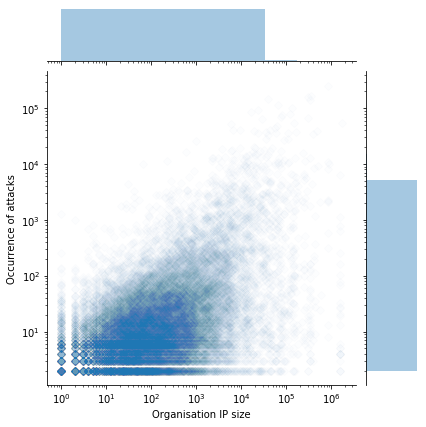

In [17]:
s = (sns.jointplot(x="org_ipsize_seen", y="count_attack", data=orgs, kind="scatter", 
                   joint_kws=dict(alpha=.01, marker="D"))
        .set_axis_labels("Organisation IP size", "Occurrence of attacks"))

s.ax_joint.set_xscale('log')
s.ax_joint.set_yscale('log')
s.ax_marg_x.set_xscale('log')

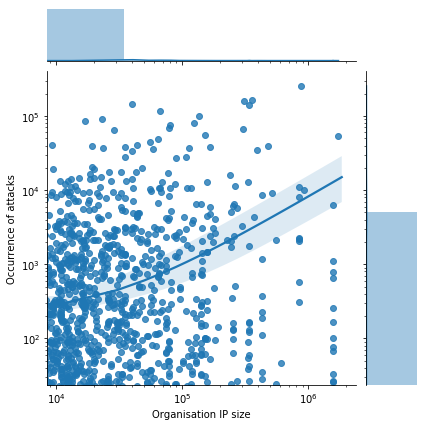

In [18]:
# regression and kernel density fits
g = (sns.jointplot(x="org_ipsize_seen", y="count_attack", data=orgs, kind="reg")
        .set_axis_labels("Organisation IP size", "Occurrence of attacks"))

g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

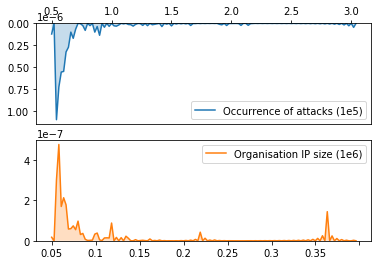

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1)
sns.kdeplot(orgs.count_attack, shade=True, ax=ax1)
sns.kdeplot(orgs.org_ipsize_seen, shade=True, ax=ax2, color="C1")
ax1.invert_yaxis(); ax1.xaxis.tick_top()
ax1.legend(["Occurrence of attacks (1e5)"], loc="lower right")
ax2.legend(["Organisation IP size (1e6)"])
# ax1.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
# ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_xticklabels([0.5*i for i in range(0, 7)]) # hard-coded labels
ax2.set_xticklabels([round(i*0.05, 2) for i in range(0, 8)]) # hard-coded labels
fig.subplots_adjust(hspace=0.15)
fig.savefig("images/kde_attacks.png")

In [20]:
# # the big hosting providers (`org_ipsize_seen` > THRESHOLD)
# orgs.loc[orgs.org_ipsize_seen > THRESHOLD]

In [21]:
# fig, ax1 = plt.subplots()
# p1 = ax1.scatter(x=orgs.org_ipsize_seen, y=orgs.count_attack_norm, marker="x", alpha=.5)
# ax1.set_ylabel("Occurrence of attacks per victim\nnormalised by IP size"), ax1.set_xlabel("IP size")
# # ax1.axvline(x=THRESHOLD, color='r', linestyle="--")

# ax2 = ax1.twinx()
# p2 = ax2.scatter(x=orgs.org_ipsize_seen, y=orgs.count_attack, marker="+", color="C1", alpha=.3)
# ax2.set_ylabel("Occurrence of attacks per victim")

# ax2.legend([p1, p2], ["normalised", "raw"], loc=0)

# plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
# plt.tight_layout()
# fig.savefig("images/attack-by-ipsize.png")

In [22]:
# fig, ax = plt.subplots(figsize=(8, 8))
# sns.scatterplot(data=orgs, x="org_ipsize_seen", y="count_attack", 
#                 hue="region", alpha=.6, size=.5, ax=ax)
# plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')
# # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.set(xscale="log", yscale="log")
# ax.set_xlabel("IP size")
# ax.set_ylabel("Occurrence of attacks")

In [23]:
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
# sns.swarmplot(x="count_attack", y="as_type", data=orgs, ax=ax[0], alpha=.3)
# # ax[0].set(xscale="log")
# # ax[0].set_xlabel(""), ax[1].set_xlabel("Occurrence of attacks")
# # ax[0].set_ylabel("Victim type")

# # sns.catplot(x="count_attack", y="caida_type", data=orgs, ax=ax[1], alpha=.3)
# # ax[1].set_ylabel("Victim type (CAIDA)")
# # fig.align_ylabels()
# # fig.subplots_adjust(hspace=0.1)
# # plt.tight_layout()
# # fig.savefig("images/attacks-by-victim-type.png")

#### Per Country

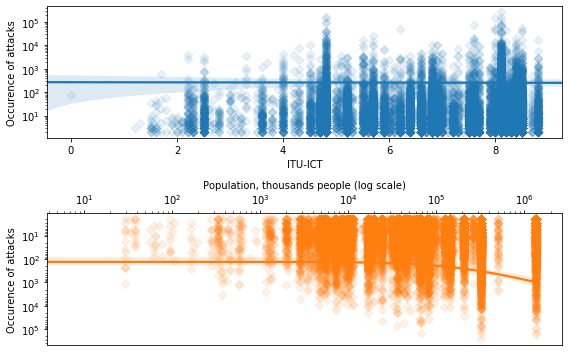

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

sns.regplot(data=orgs, x="ITU-ICT", y="count_attack", ax=ax1, marker="D", scatter_kws=dict(alpha=.1))
ax1.set(yscale="log")

sns.regplot(data=orgs, x="Population", y="count_attack", ax=ax2, marker="D", scatter_kws=dict(alpha=.1))
ax2.set(yscale="log", xscale="log")
ax2.invert_yaxis(); ax2.xaxis.tick_top(); ax2.xaxis.set_label_position("top"); ax2.set_xlabel("Population, thousands people (log scale)")

ax1.set_ylabel("Occurence of attacks"); ax2.set_ylabel("Occurence of attacks")

fig.subplots_adjust(hspace=0.4)
plt.tight_layout()
fig.savefig("images/attacks-by-country.png")

In [ ]:
# color the boxplots per region
regions = orgs.region.unique()
raw_countries = orgs.sort_values(by=["region", "raw_country"]).raw_country.unique()
colors = {regions[i] : sns.color_palette(n_colors=len(regions))[i] for i in range(len(regions))}

# repalce abbrs with fullname
regions_f = ["Western Europe",   # WE
             "North America",    # NA
             "Asian Pacific",    # AP
             "Eastern Europe",   # EE
             "Latin America",    # LC
             "Middle East",      # ME
             "Africa" ]          # AF

In [ ]:
# import matplotlib.patches as mpatches

# # plot per country
# fig, ax = plt.subplots(len(raw_countries), figsize=(8,12), sharex=True)

# for i in range(len(raw_countries)):
#     region = orgs.region[orgs.raw_country == raw_countries[i]].values[0]
#     sns.boxplot(x="count_attack", y="raw_country", orient="h", color=colors[region],
#                 data=orgs.sort_values(by=["region", "raw_country"]).loc[orgs.raw_country == raw_countries[i]], ax=ax[i])  
    
#     # formatting axis
#     ax[i].set_ylabel("")
#     ax[i].set_xlabel("")
#     ax[i].spines["top"].set_visible(False)
#     ax[i].spines["bottom"].set_visible(False)
#     ax[i].tick_params(axis='both', which='both', length=0)
    
# ax[i].set(xscale="log")
# ax[0].spines["top"].set_visible(True)
# ax[i].spines["bottom"].set_visible(True)
# ax[i].set_xlabel("Occurrence of attack against victims")
# plt.legend(handles=[mpatches.Patch(color=colors[regions[i]], label=regions_f[i]) 
#                     for i in range(len(regions))], bbox_to_anchor=(1., 1.2*len(raw_countries)),
#           title="Region")

# fig.savefig("images/attack-by-country.png")